# Import and misc

In [1]:
to_train = False

In [4]:
!wget https://raw.githubusercontent.com/ArturGoldman/KWS-HW/main/test.sh
!chmod u+x ./test.sh
!./test.sh

--2021-11-22 18:23:47--  https://raw.githubusercontent.com/ArturGoldman/KWS-HW/main/test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1637 (1.6K) [text/plain]
Saving to: ‘test.sh’

test.sh             100%[===================>]   1.60K  --.-KB/s    in 0s      

2021-11-22 18:23:47 (23.1 MB/s) - ‘test.sh’ saved [1637/1637]

--2021-11-22 18:23:49--  https://docs.google.com/uc?export=download&confirm=&id=1XN529ehTeVJvWMxDoUcG1Czing70f-td
Resolving docs.google.com (docs.google.com)... 64.233.189.138, 64.233.189.100, 64.233.189.102, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-68-docs.googleusercontent.com/docs/securesc/ikflmh57sp5

In [5]:
%pip install wandb

     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 180 kB 47.0 MB/s 
     |████████████████████████████████| 140 kB 51.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=e4fe537b53d3f216928c822a723455a50d48042cc71954b71e98a4b2f090d5af
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=8cd4df627b361322b7a6bfb41aee34e990584b1ac4f20dccfb97be16cee6a631
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [6]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
%pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 4.0 MB/s 
     |████████████████████████████████| 831.4 MB 7.0 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [8]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [9]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [10]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 18:27:59--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.8.128, 2404:6800:4008:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.8.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  48.0MB/s    in 15s     

2021-11-22 18:28:15 (93.2 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [11]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [12]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [13]:
dataset.csv.sample(5)

path keyword  label
12104   speech_commands/stop/327289eb_nohash_0.wav    stop      0
15282    speech_commands/bed/31d68957_nohash_0.wav     bed      0
52115   speech_commands/nine/b87bdb22_nohash_2.wav    nine      0
41073  speech_commands/right/edc53350_nohash_0.wav   right      0
58122  speech_commands/eight/e6db3894_nohash_0.wav   eight      0

### Augmentations

In [14]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [15]:
torch.manual_seed(68)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [16]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [17]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [18]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [19]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [20]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2)

### Creating MelSpecs on GPU for speeeed: 

In [21]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [22]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [23]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [24]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [25]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [26]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [27]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [28]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [29]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [30]:
sum([p.numel() for p in model.parameters()])

70443

In [31]:
# TRAIN
if to_train:
    wandb.init(project="KWS-HSE-DLA", name='base_model')
    for n in range(TaskConfig.num_epochs):

        train_epoch(model, opt, train_loader,
                    melspec_train, config.device)

        au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        wandb.log({"val_metric": au_fa_fr})
        clear_output()

        """
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()
        """

        print('END OF EPOCH', n)
    wandb.finish()
    torch.save(model, 'base_model.pth')

# Streaming KWS

In [32]:
@dataclasses.dataclass
class StreamConfig(TaskConfig):
    min_window_length: int = 11
    max_window_length: int = 13

In [33]:
class Streaming_CRNN(nn.Module):
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.my_crnn = CRNN(config)
        self.min_window_length = config.min_window_length
        self.max_window_length = config.max_window_length
        self.buffer = None
        # buffer: [batch, buffer_len, hidden_sz]
        self.D = 1
        if config.bidirectional:
            # this condition should never happen, because we can't stream in other direction
            # model will work, yet it will make no sense in the way it works
            self.D = 2
            print("Warning! Why is your streaming model bidirectional?")
        self.hiddens = None
        
    
    def del_first_buf(self):
        self.buffer = self.buffer[:, 1:, :]

    def add_to_buf(self, vec, hidden):
        # vec: [batch_sz, hidden_size]
        self.hidden = hidden 
        if self.buffer is None:
            self.buffer = vec.unsqueeze(1)
        else:
            self.buffer = torch.cat((self.buffer, vec.unsqueeze(1)), dim = 1)


    def forward(self, input, clear_buffer=True):
        # input: [batch, mels, sq_len]
        # output: [batch, num_classes, ...], where last dim changes depending on len of streaming audio
        output = torch.zeros((input.size()[0], self.config.num_classes, 1), device=self.config.device)
        if clear_buffer:
            self.buffer = None
            self.hiddens = None
        if self.hiddens is None:
            self.hiddens = torch.zeros((self.D*self.config.gru_num_layers, input.size()[0], self.config.hidden_size), device = self.config.device)

        ks = self.config.kernel_size[1]
        st = self.config.stride[1]

        frame_steps = (input.size()[-1]-ks)//st + 1

        for i in range(frame_steps):
            if i*st + ks >= input.size()[-1]:
                break
            cur_emb = self.my_crnn.conv(input[:, :, i*st:i*st + ks].unsqueeze(1))

            new_emb, new_hiddens = self.my_crnn.gru(cur_emb.transpose(-1, -2), self.hiddens)

            self.add_to_buf(new_emb.squeeze(1), new_hiddens)
            
            if self.buffer.size()[1] < self.min_window_length:
                continue

            if self.buffer.size()[1] > self.max_window_length:
                self.del_first_buf()

            apply_attention = self.my_crnn.attention(self.buffer)
            cur_dist = self.my_crnn.classifier(apply_attention)           
            output = torch.cat((output, cur_dist.unsqueeze(-1)), dim = -1)
        return output[:, :, 1:]

config = StreamConfig()
stream_model = Streaming_CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [34]:
sum([p.numel() for p in stream_model.parameters()])

70443

In [35]:
def train_epoch_stream(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        labels = labels.reshape(-1, 1).repeat(1, logits.size()[-1])
        # we need probabilities so we use softmax & CE separately
        #probs = F.softmax(logits, dim=1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        #argmax_probs = torch.argmax(probs, dim=-1)
        #FA, FR = count_FA_FR(argmax_probs, labels)
        #acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    #return acc

In [36]:
@torch.no_grad()
def validation_stream(model, loader, log_melspec, device):
    model.eval()

    val_losses = []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        labels = labels.reshape(-1, 1).repeat(1, output.size()[-1])
        loss = F.cross_entropy(output, labels)

        val_losses.append(loss.item())
    return val_losses

In [37]:
history = defaultdict(list)

In [38]:
config = StreamConfig()
stream_model = Streaming_CRNN(config).to(config.device)

print(stream_model)

opt = torch.optim.Adam(
    stream_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

Streaming_CRNN(
  (my_crnn): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [39]:
# TRAIN
if to_train:
    wandb.init(project="KWS-HSE-DLA", name='stream_model')
    for n in range(config.num_epochs):

        train_epoch_stream(stream_model, opt, train_loader,
                    melspec_train, config.device)

        losses = validation_stream(stream_model, val_loader,
                            melspec_val, config.device)
        history['val_metric_stream'] += [sum(losses)/len(losses)]

        wandb.log({"val_loss_stream": sum(losses)/len(losses)})
        clear_output()
        """
        plt.plot(history['val_metric_stream'])
        plt.ylabel('Val_Loss')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()
        """

        print('END OF EPOCH', n)
    wandb.finish()
    torch.save(stream_model, 'my_stream_model.pth')

## Testing streaming

In [40]:
config = StreamConfig()
stream_model = Streaming_CRNN(config)
stream_model = torch.load('my_stream_model.pth', config.device)
stream_model.config = StreamConfig()

In [41]:
import IPython
IPython.display.display(IPython.display.Audio('speech_commands/_background_noise_/dude_miaowing.wav'))
IPython.display.display(IPython.display.Audio('speech_commands/sheila/014f9f65_nohash_0.wav'))
IPython.display.display(IPython.display.Audio('speech_commands/_background_noise_/pink_noise.wav'))

In [42]:
first_wav = torchaudio.load('speech_commands/_background_noise_/dude_miaowing.wav')[0].squeeze().to(config.device)
sec_wav = torchaudio.load('speech_commands/sheila/014f9f65_nohash_0.wav')[0].squeeze().to(config.device)
third_wav = torchaudio.load('speech_commands/_background_noise_/pink_noise.wav')[0].squeeze().to(config.device)

In [43]:
first_wav.size()

torch.Size([988891])

In [44]:
melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)


def concat_sounds(a, b, c):
    first_mel = torch.log(melspec(a).clamp_(min=1e-9, max=1e9))
    sec_mel = torch.log(melspec(b).clamp_(min=1e-9, max=1e9))
    third_mel = torch.log(melspec(c).clamp_(min=1e-9, max=1e9))

    with torch.no_grad():
        out_first = stream_model(first_mel.unsqueeze(0))
        out_sec = stream_model.forward(sec_mel.unsqueeze(0), clear_buffer=False)
        out_third = stream_model.forward(third_mel.unsqueeze(0), clear_buffer=False)

    first_probs = torch.softmax(out_first, dim=1)[:, 1].squeeze()
    sec_probs = torch.softmax(out_sec, dim=1)[:, 1].squeeze()
    third_probs = torch.softmax(out_third, dim=1)[:, 1].squeeze()

    plt.figure(figsize=(14, 10))
    plt.plot(first_probs.cpu().tolist(), label = 'first_part')
    plt.plot(np.arange(0, sec_probs.size()[0])+first_probs.size()[0], sec_probs.cpu().tolist(), label = 'second_part')
    plt.plot(np.arange(0, third_probs.size()[0])+first_probs.size()[0]+sec_probs.size()[0], third_probs.cpu().tolist(), label = 'third_part')
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


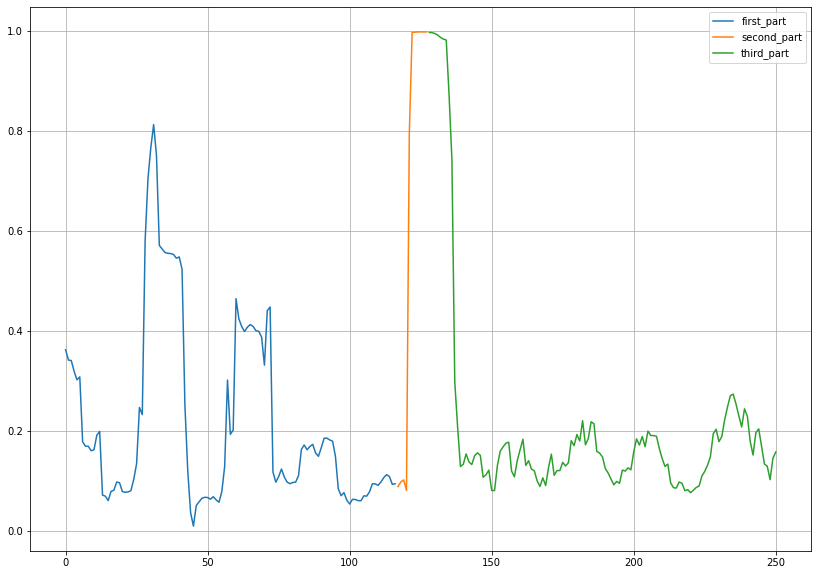

In [45]:
concat_sounds(first_wav[:int(first_wav.size()[0]/6)], sec_wav, third_wav[:int(third_wav.size()[0]/6)])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


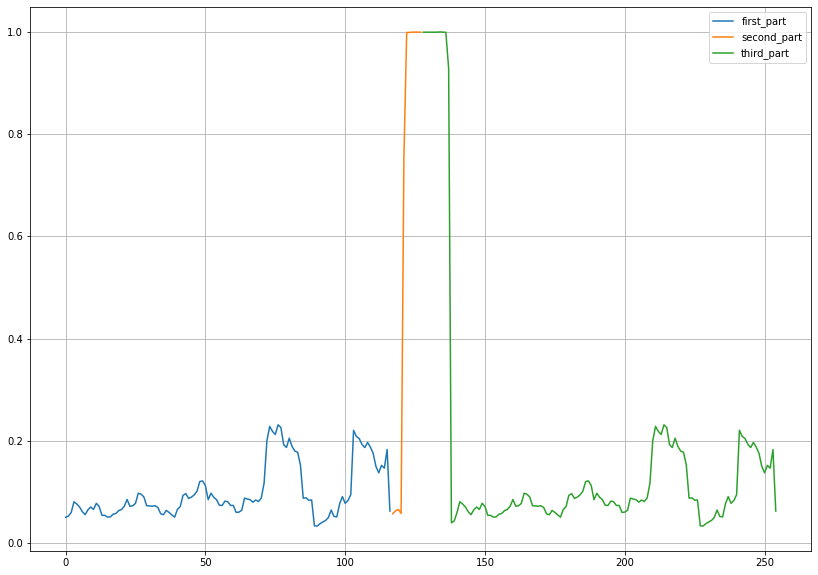

In [46]:
concat_sounds(first_wav[int(5*first_wav.size()[0]/6):int(first_wav.size()[0])], sec_wav, first_wav[int(5*first_wav.size()[0]/6):int(first_wav.size()[0])])

# Distillation

In [47]:
def train_epoch_dist(model, teacher_model, opt, loader, log_melspec, device, T=10, alpha=1, beta=0.5):
    model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits_stud = model(batch)
        with torch.no_grad():
            logits_teach = teacher_model(batch)
        # we need probabilities so we use softmax & CE separately
        log_probs_temp_st = F.log_softmax(logits_stud/T, dim=-1)
        probs_temp_tch = F.softmax(logits_teach/T, dim=-1)

        # cross entropy between distributions
        loss_ce = -(probs_temp_tch*log_probs_temp_st).sum(dim=-1).mean()

        # basic student loss
        loss_student = F.cross_entropy(logits_stud, labels)

        # can be weighted
        loss = alpha*loss_student + beta*loss_ce

        probs = F.softmax(logits_stud, dim=-1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [48]:
@dataclasses.dataclass
class DistilledConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (10, 10)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
history = defaultdict(list)
dist_config = DistilledConfig()
dist_model = CRNN(dist_config).to(dist_config.device)

teacher_config = TaskConfig()
teacher_model = CRNN(teacher_config)
teacher_model = torch.load('base_model.pth', teacher_config.device)
teacher_model.config = teacher_config

print(dist_model)

opt = torch.optim.Adam(
    dist_model.parameters(),
    lr=dist_config.learning_rate,
    weight_decay=dist_config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(20, 20), stride=(10, 10))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(12, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [50]:
# TRAIN
if to_train:
    wandb.init(project="KWS-HSE-DLA", name='distilled_model-try')
    for n in range(dist_config.num_epochs):

        train_epoch_dist(dist_model, teacher_model, opt, train_loader,
                    melspec_train, dist_config.device)

        au_fa_fr = validation(dist_model, val_loader,
                            melspec_val, dist_config.device)
        history['val_metric'].append(au_fa_fr)

        wandb.log({"val_metric": au_fa_fr})
        
        
        clear_output()

        """
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()
        """

        print('END OF EPOCH', n)
    wandb.finish()
    torch.save(dist_model, 'dist_model.pth')

# Base fp 16

In [51]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [52]:
class LogMelspec16:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-4, max=1e5)).half()

In [53]:
melspec_train_16 = LogMelspec16(is_train=True, config=TaskConfig)
melspec_val_16 = LogMelspec16(is_train=False, config=TaskConfig)

In [54]:
config = TaskConfig()
model = CRNN(config).to(config.device).half()
config.learning_rate = 1e-2
print(model)

opt = torch.optim.SGD(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [55]:
# TRAIN
if to_train:
    wandb.init(project="KWS-HSE-DLA", name='base_model_fp16')
    for n in range(TaskConfig.num_epochs):

        train_epoch(model, opt, train_loader,
                    melspec_train_16, config.device)

        au_fa_fr = validation(model, val_loader,
                            melspec_val_16, config.device)
        history['val_metric'].append(au_fa_fr)

        wandb.log({"val_metric": au_fa_fr})
        clear_output()

        """
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()
        """

        print('END OF EPOCH', n)
    wandb.finish()
    torch.save(model, 'base_model_f16.pth')

# f16 + train vs train + f16

In [56]:
config = TaskConfig()
model = CRNN(config).to(config.device).half()
config.learning_rate = 1e-2
print(model)

config = TaskConfig()
base_model = CRNN(config)
base_model = torch.load('base_model.pth', config.device)
base_model.config = config

base_model_f16 = CRNN(config).half()
base_model_f16 = torch.load('base_model_f16.pth', config.device)
base_model_f16.config = config

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [57]:
melspec_val_16 = LogMelspec16(is_train=False, config=TaskConfig)

au_fa_fr = validation(base_model.half(), val_loader,
                            melspec_val_16, config.device)

au_fa_fr_f16 = validation(base_model_f16, val_loader,
                            melspec_val_16, config.device)

102it [00:07, 14.01it/s]
102it [00:06, 14.94it/s]


In [58]:
print(au_fa_fr, au_fa_fr_f16)

1.3808905102715667e-05 5.950838447894582e-05


# Quantization

In [59]:
@dataclasses.dataclass
class QuantConfig(TaskConfig):
    device: torch.device='cpu'

In [60]:
base_config = QuantConfig()
base_model = CRNN(base_config)
base_model = torch.load('base_model.pth', base_config.device)
base_model.config = base_config

quant_model = torch.quantization.quantize_dynamic(
    base_model,  # the original model
    {torch.nn.GRU, torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

In [61]:
quant_melspec_val = LogMelspec(is_train=False, config=base_config)

au_fa_fr = validation(quant_model, val_loader,
                            quant_melspec_val, base_config.device)
print(au_fa_fr)

102it [00:11,  8.97it/s]


2.3774709563188943e-05


# Compare models

In [62]:
# TODO: compare val loss, memory, mops, time? draw it on one graph

In [63]:
models_to_test = ['quant_base_model', 'quant_dist_model', 'base_model', 'dist_model', 
                  'base_model_tof16', 'dist_model_tof16', 'base_model_f16']
configs = [TaskConfig(), DistilledConfig(), TaskConfig(), DistilledConfig(), 
           TaskConfig(), DistilledConfig(), TaskConfig()]

In [64]:
from pathlib import Path

def met_mem(models, configs):
    plt.figure(figsize=(14, 8))
    
    coords = []
    
    for i in range(len(models)):
        
        name_to_use = models[i].replace('_tof16', '')

        if 'quant_' in models[i]:
          real_name = name_to_use.replace('quant_', '')
          configs[i].device = 'cpu'

          model = CRNN(configs[i])
          model = torch.load(real_name+'.pth', configs[i].device)
          model.config = configs[i] 

          model = torch.quantization.quantize_dynamic(
                        model,  # the original model
                        {torch.nn.GRU, torch.nn.Linear},  # a set of layers to dynamically quantize
                        dtype=torch.qint8)
          torch.save(model, models[i]+'.pth')
        else:
          model = CRNN(configs[i])
          model = torch.load(name_to_use+'.pth', configs[i].device)
          model.config = configs[i]
        
        if '_tof16' in models[i] or '_f16' in models[i]:
            melspec_val = LogMelspec16(is_train=False, config=configs[i])
            if '_tof16' in models[i]:
                model = model.half()
                torch.save(model, models[i]+'.pth')
        else:
            melspec_val = LogMelspec(is_train=False, config=configs[i])

        au_fa_fr = validation(model, val_loader,
                            melspec_val, configs[i].device)
        cur_mem = Path(models[i]+'.pth').stat().st_size/(2**10)
        coords.append([cur_mem, au_fa_fr])
        
    coords = np.array(coords)
    plt.scatter(coords[:, 0], coords[:, 1])
    for i in range(len(models)):
        plt.annotate(models[i], (coords[i, 0] + 1000/(2**10), coords[i, 1]))
    
    plt.xlabel('Memory, KBs')
    plt.ylabel('Metric AUC FA FR')
    plt.grid()
    plt.savefig('mem.eps')
    plt.show()

    return coords

102it [00:11,  8.89it/s]
102it [00:11,  8.87it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
102it [00:06, 14.63it/s]
102it [00:06, 14.77it/s]
102it [00:06, 14.77it/s]
102it [00:06, 15.06it/s]
102it [00:06, 14.96it/s]


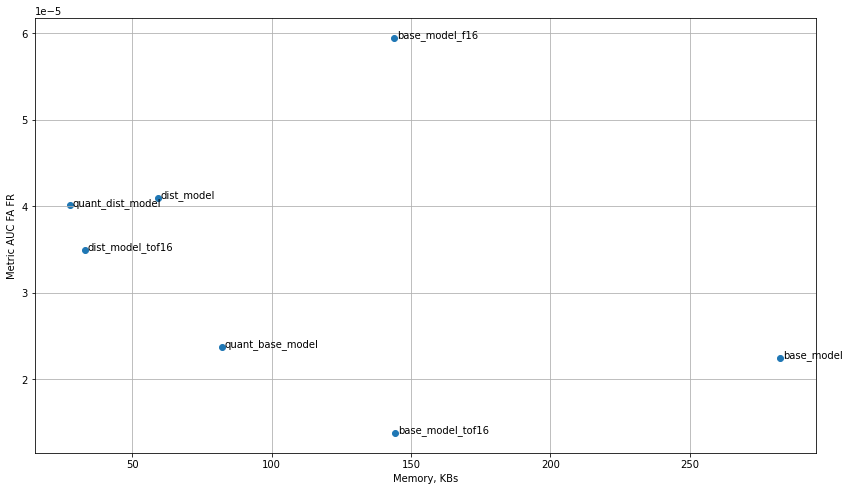

In [65]:
metrics = met_mem(models_to_test, configs)

In [66]:
import pandas as pd
description = pd.DataFrame(metrics, models_to_test, ['Memory, KBs', 'Metric AUC FA FR'])

In [67]:
description

Memory, KBs  Metric AUC FA FR
quant_base_model    82.176758          0.000024
quant_dist_model    27.676758          0.000040
base_model         282.551758          0.000023
dist_model          59.135742          0.000041
base_model_tof16   144.260742          0.000014
dist_model_tof16    33.073242          0.000035
base_model_f16     143.948242          0.000060

In [68]:
!pip install thop

In [69]:
from thop import profile 

def met_macs(models, configs):
    plt.figure(figsize=(14, 8))
    
    coords = []

    next_batch = next(iter(val_loader))
    melspec_val = LogMelspec(is_train=False, config=config)
    batch = melspec_val(next_batch[0].to(config.device))
    
    for i in range(len(models)):
        name_to_use = models[i].replace('_tof16', '')

        if 'quant_' in models[i]:
          real_name = name_to_use.replace('quant_', '')
          configs[i].device = 'cpu'

          model = CRNN(configs[i])
          model = torch.load(real_name+'.pth', configs[i].device)
          model.config = configs[i] 

          model = torch.quantization.quantize_dynamic(
                        model,  # the original model
                        {torch.nn.GRU, torch.nn.Linear},  # a set of layers to dynamically quantize
                        dtype=torch.qint8)
          torch.save(model, models[i]+'.pth')
        else:
          model = CRNN(configs[i])
          model = torch.load(name_to_use+'.pth', configs[i].device)
          model.config = configs[i]
        
        if '_tof16' in models[i] or '_f16' in models[i]:
            melspec_val = LogMelspec16(is_train=False, config=configs[i])
            if '_tof16' in models[i]:
                model = model.half()
                torch.save(model, models[i]+'.pth')
        else:
            melspec_val = LogMelspec(is_train=False, config=configs[i])

        au_fa_fr = validation(model, val_loader,
                            melspec_val, configs[i].device)
        if '_tof16' in models[i] or '_f16' in models[i]:
            macs, params = profile(model, (batch.to(configs[i].device).half(), )) 
        elif 'quant_' in models[i]:
            real_name = name_to_use.replace('quant_', '')

            model = CRNN(configs[i])
            model = torch.load(real_name+'.pth', configs[i].device)
            model.config = configs[i] 
            macs, params = profile(model, (batch.to(configs[i].device), )) 
        else:
            macs, params = profile(model, (batch.to(configs[i].device), )) 
        
        coords.append([macs, au_fa_fr, params])
        
    coords = np.array(coords)
    plt.scatter(coords[:, 0], coords[:, 1])
    for i in range(len(models)):
        plt.annotate(models[i], (coords[i, 0] + 1000/(2**10), coords[i, 1]))
    
    plt.xlabel('MACs')
    plt.ylabel('Metric AUC FA FR')
    plt.grid()
    plt.savefig('macs.eps')
    plt.show()

    return coords

102it [00:12,  8.49it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


102it [00:11,  8.70it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
102it [00:07, 14.35it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


102it [00:06, 14.88it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


102it [00:06, 14.78it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


102it [00:07, 14.50it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


102it [00:07, 14.51it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


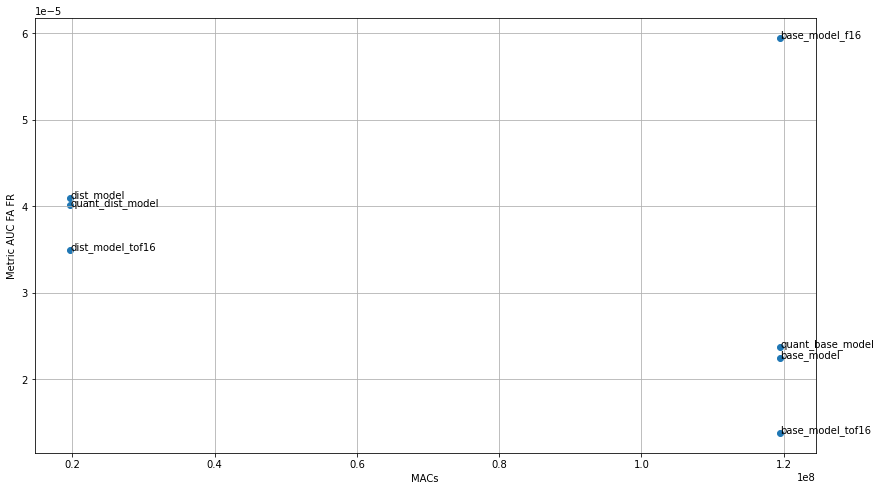

In [70]:
metrics_sec = met_macs(models_to_test, configs)

In [71]:
description_sec = pd.DataFrame(metrics_sec, models_to_test, ['MACs', 'Metric AUC FA FR', 'Params'])

In [72]:
description_sec

MACs  Metric AUC FA FR   Params
quant_base_model  119527424.0          0.000024  70443.0
quant_dist_model   19670528.0          0.000040  13511.0
base_model        119527424.0          0.000023  70443.0
dist_model         19670528.0          0.000041  13511.0
base_model_tof16  119527424.0          0.000014  70443.0
dist_model_tof16   19670528.0          0.000035  13511.0
base_model_f16    119527424.0          0.000060  70443.0

In [73]:
rate1 = description.loc['base_model'][0]/description.iloc[:, 0].min()
rate2 = description_sec.loc['base_model'][0]/description_sec.iloc[:, 0].min()
print("Rate 1:", rate1)
print("Rate 2:", rate2)
print("Unbounded Mark:", 0.4*(rate1 + rate2))
print("Bounded Mark:", 0.4*(min(10, rate1) + min(10, rate2)))

Rate 1: 10.208990508450654
Rate 2: 6.0764725786720115
Unbounded Mark: 6.514185234849066
Bounded Mark: 6.430589031468805
